In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
def index_psmid_table(table_file, psmid):
    table = pd.read_csv(table_file, sep='\t', usecols=['SpecId', 'spectral_angle'])
    return table[table['SpecId'].apply(lambda x: x in psmid)]

def shared_psmid(nf_psms, f_psms, threshold=0.01):
    nf = pd.read_csv(nf_psms, sep='\t')
    f = pd.read_csv(f_psms, sep='\t')
    nf_psmid = nf[nf['q-value'] <= threshold]['PSMId']
    f_psmid = f[f['q-value'] <= threshold]['PSMId']
    return set(nf_psmid).intersection(f_psmid)

In [35]:
def set_axis_style(ax, labels, fontsize):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1),)
    ax.set_xticklabels(labels, fontsize=fontsize)
    ax.set_xlim(0.25, len(labels) + 0.75)
    # ax.set_xlabel('Sample name')

def plot_half_violin(data_dict : dict, figsize=(4, 6), fontsize=15):
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    labels = list(data_dict)

    no_finetuned = [v[0] for v in data_dict.values()] 
    finetuned = [v[1] for v in data_dict.values()] 

    mins = [min(np.min(i), np.min(j)) for i, j in zip(no_finetuned, finetuned)]
    maxs = [max(np.max(i), np.max(j)) for i, j in zip(no_finetuned, finetuned)]

    plot1 = ax.violinplot(no_finetuned, showmeans=False, showextrema=False, showmedians=False)
    for b in plot1['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
        b.set_edgecolor('lightgray')
        # b.set_edgewidth(2)
    plot2 = ax.violinplot(finetuned, showmeans=False, showextrema=False, showmedians=False)
    for b in plot2['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further left than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        # b.set_color('b')
        b.set_edgecolor('lightgray')
        # b.set_edgewidth(2)
    for i in range(len(labels)):
        ax.text(i+1-0.2, 0.4, f"n={len(finetuned[i])}", fontsize=8, rotation=90, va='center')
    # ax.vlines([i+1 for i in range(len(labels))], mins, maxs, color='gray', linestyles='--', lw=1)
    
    x_axises = np.array([i+1 for i in range(len(labels))])
    nf_sa_mean = [np.mean(i) for i in no_finetuned]
    f_sa_mean = [np.mean(i) for i in finetuned]

    ax.hlines(nf_sa_mean, x_axises-0.2, x_axises, color='slateblue', linestyles='-', lw=1)
    ax.hlines(f_sa_mean, x_axises, x_axises+0.2, color='orange', linestyles='-', lw=1)
    ax.legend([plot1['bodies'][0],plot2['bodies'][0]],['No fine-tuned', 'Fine-tuned'], loc='lower right', frameon=False)
    set_axis_style(ax, labels, fontsize)
    ax.set_ylabel("Spectral Angle", fontsize=15)
    return fig, ax

    

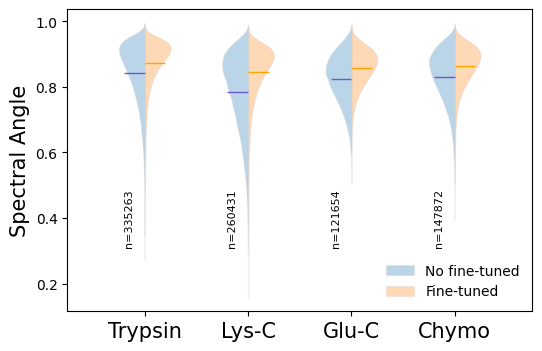

In [98]:
whichs = ['trypsin', "lysc", 'gluc', "chymo"]
data_dict = {}
frag_model = "prosit_l1"
for which, show in zip(whichs, ["Trypsin", "Lys-C", "Glu-C", "Chymo"]):
    result_dir = f"/data/prosit/figs/fig235/{which}/percolator_up/try/{frag_model}"
    no_finetuned_dir = os.path.join(result_dir, "no_finetuned_twofold")
    finetuned_dir = os.path.join(result_dir, "finetuned_twofold")
    nf_psms = os.path.join(no_finetuned_dir, "sa_target.psms")
    nf_table = os.path.join(no_finetuned_dir, "sa.tab")
    f_psms = os.path.join(finetuned_dir, "sa_target.psms")
    f_table = os.path.join(finetuned_dir, "sa.tab")
    share_psmids = shared_psmid(nf_psms, f_psms)

    nf_tab = index_psmid_table(nf_table, share_psmids)
    f_tab = index_psmid_table(f_table, share_psmids)
    nf_sa = nf_tab['spectral_angle']
    f_sa = f_tab['spectral_angle']
    data_dict[show] = (nf_sa, f_sa)
    
fig, ax = plot_half_violin(data_dict)
fig.savefig(f"fig/fig2-violin-fdr-sa-{frag_model}.svg", dpi=300)

In [29]:
import h5py

def index_psmid_table(table_file, psmid):
    table = pd.read_csv(table_file, sep='\t', usecols=['SpecId', 'spectral_angle'])
    return table[table['SpecId'].apply(lambda x: x in psmid)]

def shared_psmid(nf_psms, f_psms, threshold=0.01):
    nf = pd.read_csv(nf_psms, sep='\t')
    f = pd.read_csv(f_psms, sep='\t')
    nf_psmid = ["-".join(i.split('-')[:-1]) for i in nf[nf['q-value'] <= threshold]['PSMId']]
    f_psmid = f[f['q-value'] <= threshold]['PSMId']
    return set(nf_psmid).intersection(f_psmid)

def track_raw_spectrum(table, psmids):
    intens = []
    psmid2sa = {
        "-".join([str(k), str(v)]): j 
        for k, v, j in zip(table['raw_file'], table['scan_number'], table['spectral_angle'])
    }
    for psmid in psmids:
        packs = psmid.split("-")
        charge = int(packs[-1])
        pep = packs[-2]
        sn = int(packs[-3])
        rf = '-'.join(packs[:-3])
        
        # re = table[(table['raw_file'] == rf) & (table['scan_number'] == sn)]
        sa = psmid2sa['-'.join([str(rf), str(sn)])]
        intens.append(sa)
    return intens

data_dict = {}

frag_model = "prosit_l1"
set_threshold = 0.1
hla_mel = pd.read_csv("./data/HLA_Mel.csv")
hla_mel = hla_mel[hla_mel['Experiment'].apply(
    lambda x: x.endswith("HLA-I"))]
Mels = hla_mel['Experiment'].unique()

for which in Mels:
    print(which)
    f_tab = f"/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_1/{frag_model}/percolator_hdf5_Mels_{set_threshold}/{which}"
    nf_tab = f"/data/yejb/prosit/figs/boosting/figs/Figure_5_HLA_1/forPride/rescoring_for_paper_2/Mels/{which}/percolator"
    f_psms = os.path.join(f_tab, "prosit_target.psms")
    f_table = os.path.join(f_tab, "prosit.tab")
    hdf5_file = os.path.join(nf_tab, "features.csv")
    nf_psms = os.path.join(nf_tab, "prosit_target.psms")
    nf_table = os.path.join(nf_tab, "prosit.tab")
    
    hdf5_data = pd.read_csv(hdf5_file, usecols=["raw_file", "scan_number", "spectral_angle"])
    share_psmids = shared_psmid(nf_psms, f_psms)

    f_tab = index_psmid_table(f_table, share_psmids)
    nf_sa = track_raw_spectrum(hdf5_data, share_psmids)
    # nf_tab = index_psmid_table(nf_table, share_psmids)
    # nf_sa = nf_tab['spectral_angle']
    f_sa = f_tab['spectral_angle']
    print(len(nf_sa), len(f_sa))
    data_dict[which.split('_')[0]] = (nf_sa, f_sa)

Mel-3_HLA-I
34453 34453
Mel-4_HLA-I
39574 39574
Mel-12_HLA-I
45994 45994
Mel-5_HLA-I
46578 46578
Mel-8_HLA-I
53528 53528
Mel-15_HLA-I
416330 416330
Mel-16_HLA-I
251200 251200
Mel-21_HLA-I
66941 66941
Mel-27_HLA-I
61857 61857
Mel-28_HLA-I
37985 37985
Mel-41_HLA-I
53820 53820
Mel-24_HLA-I
33094 33094
Mel-30_HLA-I
24060 24060
Mel-38_HLA-I
16259 16259
Mel-39_HLA-I
42895 42895
Mel-25_HLA-I
25026 25026
Mel-26_HLA-I
30276 30276
Mel-29_HLA-I
30245 30245
Mel-33_HLA-I
38568 38568
Mel-36_HLA-I
31975 31975
Mel-40_HLA-I
13170 13170
Mel-20_HLA-I
9026 9026
Mel-34_HLA-I
10576 10576
Mel-35_HLA-I
18351 18351
Mel-42_HLA-I
19681 19681


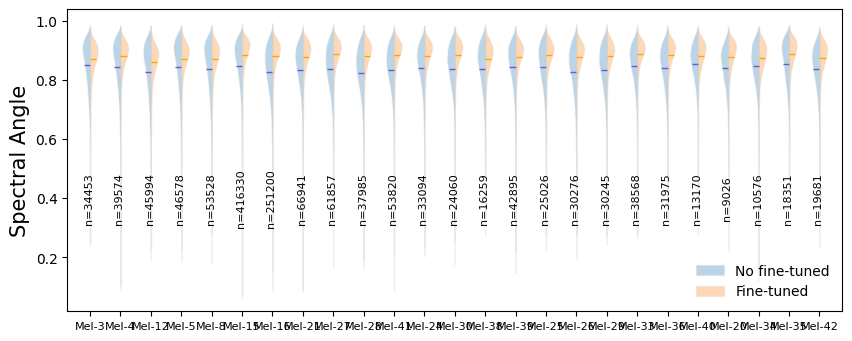

In [36]:
fig, ax = plot_half_violin(data_dict, figsize=(10, 4), fontsize=8)